# Using a battery to cut power peaks
There is a limit to the amount of power that can be transmitted by a power grid. My local power grid is at that limit. When in such a situation two things can be done. On the one hand the grid can be upgraded to carry more power. The other way to tackle the problem is to reduce the amount of power the grid has to deliver. The goal of the project given to my team was to cut power peaks for a facility by using a programmable battery in order to free up capacity on the grid. To do this we came up with an control algorithm which we tested by constructing a model of the battery and running it with real hourly power consumption data as input. In this post I will demonstrate how we came up with the first model. In later posts I will show how I've since altered/improved the model. The original model was written in Matlab. In writing this post I'm reacquainting myself with python and learning how to use jupyter.

### A note on power vs. energy
I like the analogy "power is to energy what velocity is to distance". In this project we are not concerned with "how far" (energy) the power grid can go, but rather by "how fast" (power) it is going. The basic unit of energy is the Joule, denoted 'J' and the basic unit of power is the Watt, denoted with a 'W'. Power is the time derivative of energy, so one Watt is the same as One Joule per second.

### A note on units
In this project Joules and Watts are rarely (if ever) used in their basic form. Rather we measure power in kilowatts (kW) and energy in kilowatt hours (kWh). Using the kWh to represent energy took some getting used to. Consuming one kilowatt of power for the duration of one hour results in the total energy consumption for the hour being one kilowatt hour. Looking at the units, things become a bit more clear. Multiplying a power with the duration of the power means that time "cancels out", yielding only energy in the same way as multiplying a velocity with its duration gives a distance.

## The raw data
The power consumption data we were given consisted of hourly average values in kW. The data stretched back for as long as the facilites had been around. Both were quite new, so we had about a couple of years worth. Below is some code for accessing the data, stored in .txt-files, together with a graph showing power consumtion over time.




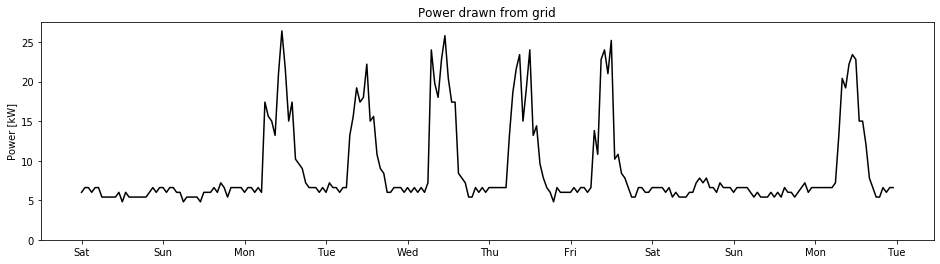

In [56]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import matplotlib.dates as mdates
import datetime
DATAFILE = "../data/Sep2018.txt"
loadvec = np.loadtxt(DATAFILE).reshape(-1,1)
loadvec = loadvec[:240]
days = [datetime.datetime(2018, 9, 1) + datetime.timedelta(hours = x) for x in range(len(loadvec))]
fig, ax = plt.subplots(figsize = (16,4))
_ = ax.plot(days, loadvec, 'k')
weekday = mdates.DayLocator()  # every month
years_fmt = mdates.DateFormatter('%a')
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(weekday)
ax.set_ylim([0, None])
ax.set_ylabel('Power [kW]')
ax.set_title('Power drawn from grid')
plt.show()

### Base load and solar panels
It is quite plain to see when the facility is being used. There is usually a distinct peak each monday through friday, followed by a rest period during the weekend. The power seems not to want to reach zero, but rather seems to default to slightly more than 5 kW when the facility is not in use. This is what we call the 'base load' of the facility and includes all things that need to run constantly, like refridgerators, ventilation, heat pumps etc. About halfway through this month solar panels were installed. This sometimes reduces the power drawn from the grid to zero. It is important to remember that the power _consumption_ is not zero, but rather the power _drawn from the grid_. 

### Compared to regular households
The power consumption for this facility is in some sense an inverse of a typical household consumtion. In a household we typically see a small bump in the morning (making breakfast, showering etc.), followed by base load until poeple get home from work in the evening and make dinner. The facility has a peak in the middle of the day which is pretty typical for a workplace.

## Coming up with an algorithm
There are two ways to control the battery. One is to have it follow a schedule and the other is to have it read power consumption i real time and act accordingly. We chose to do the latter of the two. For this a threshold is needed, where the battery is activated and starts providing power. We call this threshold the _activation power_.

### Determining what the battery should do
The power at which the battery should work is determined by comparing the current power usage with the activation power, resulting in four cases:
-  The power drawn from the grid is greater than the activation power by more than the maximum power output of the battery. The battery should discharge at full power.
-  The power drawn from the grid is greater than the activation power by less than the maximum power of the battery. The battery should output the difference so that the power drawn from the grid equals the activation power.
-  The power drawn from the grid is less than the activation power by more than the maximum power of the battery. The battery should charge at full power.
-  The power drawn from the grid is less than the activation power by less than the maximum power of the battery. The battery should charge at the difference so that the power drawn from the grid equals the activation power.
From these cases an instruction for battery power is created. This is done in the function `determine_P_instruct` [(link to code)](https://github.com/albinbjorn/battery_simulator/blob/master/src/battery_hour_data.py#L3).

### Determining what the battery will actually do
It might not be possible to follow the instruction. The instruction might for example be to charge while the battery is full. The resulting power of the battery should in this case not be to charge, but rather to do nothing. Six more cases determine what the battery will do by comparing the instruction with the current state of charge (SoC):
#### The discharging cases
-  The instruction is to discharge and the SoC is at zero. The battery power is set to zero.
-  The instruction is to discharge and will run out of charge before the next instruction comes. The battery is set to discharge so it reaces zero when the next instruction comes.
-  The instruction is to discharge and there is enough charge in the battery to do so for the full duration. The battery is set to discharge at the instructed power.

#### The charging cases
These are like a mirror image of the discharge cases.
-  The instruction is to charge and the SoC is at its maximum. The battery power is set to zero.
-  The instruction is to charge and the battery will be completely full before the next instruction comes. The battery is set to charge so that it becomes full when the next instruction comes.
-  The instruction is to charge and there is enough "room" left in the battery to do so for the full duration. The battery is set to charge at the instructed power.

The actual power of the battery is determined in the function `determine_P_actual` [(link to code)](https://github.com/albinbjorn/battery_simulator/blob/master/src/battery_hour_data.py#L15). The sign convention I've chosen is the following: Charging the battery means the power is positive and discharging the battery means the power is negative. Let's see how the model battery works when given the data shown earlier! The battery parameters are the same as for the real battery at the facility, that is 6 kW maximum power and 24 kWh storage capacity. The activation power in this example is set to 16 kW.

In [57]:
sys.path.append("../src")
from battery_hour_data import batt_algo

In [58]:
[P_batt, SoC] = batt_algo(loadvec, 16, 6, 24, 24)

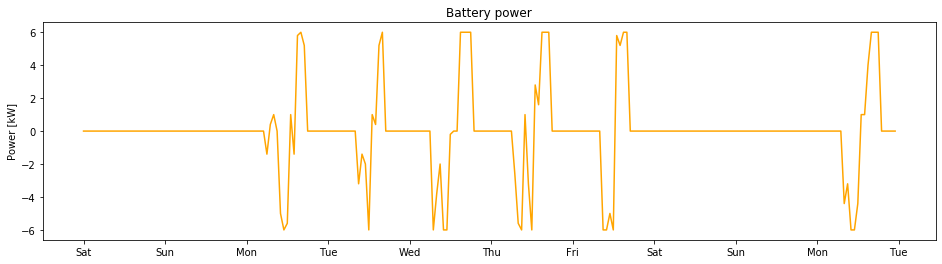

In [59]:
fig, ax = plt.subplots(figsize = (16,4))
_ = ax.plot(days, P_batt, color = 'orange')
weekday = mdates.DayLocator()  # every month
years_fmt = mdates.DateFormatter('%a')
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(weekday)
ax.set_title('Battery power')
ax.set_ylabel('Power [kW]')
plt.show()

The battery seems to work fine, going between -6 kW and 6 kW as needed. To see the effect the battery has on the power drawn from the grid we can simply add the battery power vector (P_batt) to the load vector (loadvec). A normal element-wise addition will do since the sign convention is that when the battery is discharging it has a negative sign and reduces the power from the grid.

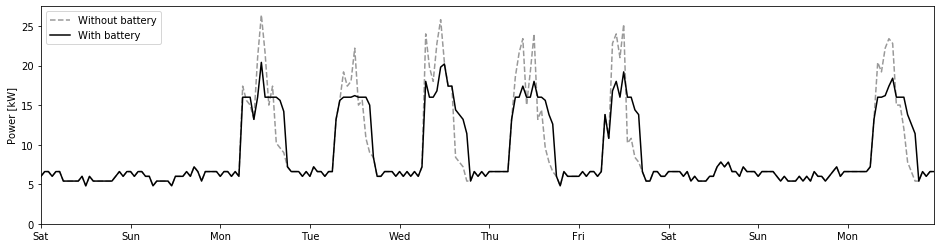

In [66]:
fig, ax = plt.subplots(figsize = (16,4))
_ = ax.plot(days, loadvec, '--k', alpha = 0.4, label = 'Without battery')
_ = ax.plot(days, loadvec + P_batt, 'k', label = 'With battery')
weekday = mdates.DayLocator()  # every month
years_fmt = mdates.DateFormatter('%a')
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_major_locator(weekday)
ax.set_ylim([0, None])
ax.set_xlim([days[0], days[-1]])
ax.set_ylabel('Power [kW]')
plt.legend()
plt.show()

The case demonstrated here is what we had to work with when doing the project. We were supposed to get live data at intervals of a couple of minutes, but never managed to communicate with the programmable logic controller (PLC). We instead used historical hourly data. Using hourly data made conversion between power and energy very simple since every time step is an hour long and the battery works at a constant power for that hour, the power and the energy (in kw and kWh) will have the same value.